<a href="https://colab.research.google.com/github/jwbarbona/labo2025v/blob/main/final%20DMA%201_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler

# 1. Preparación de Datos
t = np.linspace(0, 100, 1000)
data = np.sin(t) + np.random.normal(0, 0.08, 1000)
data = data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, look_back=30):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("Datos listos en memoria.")

Datos listos en memoria.


In [2]:
architectures = [
    {"name": "Pequeno_1x16", "layers": [16], "color": "red"},
    {"name": "Mediano_1x64", "layers": [64], "color": "green"},
    {"name": "Profundo_2_capas", "layers": [64, 32], "color": "blue"},
    {"name": "Complejo_3_capas", "layers": [128, 64, 32], "color": "orange"}
]

predictions = {}
histories = {}

for arch in architectures:
    model = Sequential(name=arch["name"])
    model.add(Input(shape=(look_back, 1)))
    for i, units in enumerate(arch["layers"]):
        model.add(LSTM(units, return_sequences=(i < len(arch["layers"]) - 1)))
        model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                        validation_data=(X_test, y_test), verbose=0)

    histories[arch["name"]] = history.history
    pred = model.predict(X_test)
    predictions[arch["name"]] = scaler.inverse_transform(pred)
    print(f"✓ {arch['name']} entrenado.")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
✓ Pequeno_1x16 entrenado.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
✓ Mediano_1x64 entrenado.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
✓ Profundo_2_capas entrenado.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
✓ Complejo_3_capas entrenado.


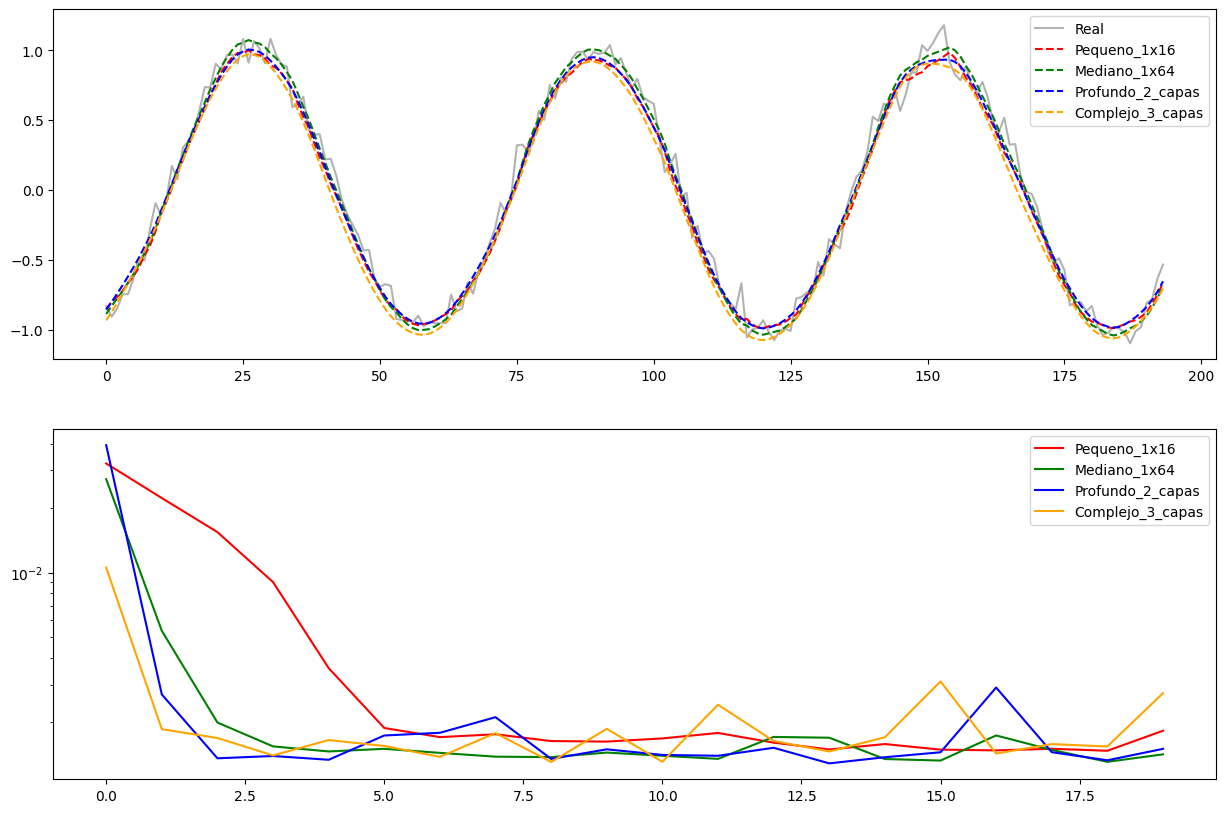

In [3]:
# Gráficos de resultados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

ax1.plot(y_test_actual, label='Real', color='black', alpha=0.3)
for arch in architectures:
    ax1.plot(predictions[arch["name"]], label=arch["name"], color=arch["color"], linestyle='--')
ax1.legend()

for arch in architectures:
    ax2.plot(histories[arch["name"]]['val_loss'], label=arch["name"], color=arch["color"])
ax2.set_yscale('log')
ax2.legend()
plt.show()

In [4]:
# 1. Seleccionamos el último ejemplo del conjunto de prueba
indice_ejemplo = -1  # El último disponible
input_ejemplo = X_test[indice_ejemplo].reshape(1, look_back, 1)
valor_real_escalado = y_test[indice_ejemplo]

# 2. Des-escalamos el valor real para entenderlo
valor_real = scaler.inverse_transform([[valor_real_escalado]])[0][0]

print(f"--- Prueba de Predicción Individual ---")
print(f"Valor Real (Objetivo): {valor_real:.4f}\n")

# 3. Pedimos a cada modelo su "opinión"
for arch in architectures:
    # Recuperamos el modelo por su nombre (necesita estar en el ámbito actual)
    # Nota: Este bloque asume que los modelos se entrenaron en la celda anterior
    # Para hacerlo más robusto, usaremos las predicciones que ya guardamos
    pred_final = predictions[arch["name"]][indice_ejemplo][0]
    error = abs(valor_real - pred_final)

    print(f"Modelo: {arch['name']}")
    print(f"  > Predicción: {pred_final:.4f}")
    print(f"  > Error Absoluto: {error:.4f}")
    print("-" * 30)

--- Prueba de Predicción Individual ---
Valor Real (Objetivo): -0.5341

Modelo: Pequeno_1x16
  > Predicción: -0.6646
  > Error Absoluto: 0.1305
------------------------------
Modelo: Mediano_1x64
  > Predicción: -0.6855
  > Error Absoluto: 0.1514
------------------------------
Modelo: Profundo_2_capas
  > Predicción: -0.6542
  > Error Absoluto: 0.1202
------------------------------
Modelo: Complejo_3_capas
  > Predicción: -0.7051
  > Error Absoluto: 0.1710
------------------------------
